# Hierarchical models with mixed centered and non-centered parameterizations

## Background

In his post on [hierarchical models](https://betanalpha.github.io/assets/case_studies/hierarchical_modeling.html), Michael Betencourt goes in-depth on the *funnel pathologies* that often plague hierarchical modeling.
In general, with weakly-informative likelihoods in the individual distributions, centered parameterizations will demonstrate strong funnel geometries that can be fixed by a non-centered parameterization.
Alternatively, when the individual distributions are narrow (i.e. highly-informative), the centered parameterization is superior to the non-centered parameterization (though the funnel degenergy is somewhat mitigated by partial pooling of information).
Importantly, these general conclusions are only in reference to "uniformally-informative" individual likelihoods – not when some individuals have a lot more data than others.
For this case, Betencourt [creates a model](https://betanalpha.github.io/assets/case_studies/hierarchical_modeling.html#423_Unbalanced_Likelihood_Functions) with a mixture of centered parameterizations for the weakly-informed cases and non-centered parameterizations for strongly-informated cases.
My goal here is to reproduce this type of model in PyMC3.

Below is the Stan model that Betencourt creates followed by the diagram he included to explain its structure:

```text
data {
  int<lower=0> N;      // Number of observations
  vector[N] y;         // Observations
  real<lower=0> sigma; // Measurement variability
  
  // Number of individual contexts in hierarchy
  int<lower=0> K;
  // Individual context from which each observation is generated
  int<lower=1, upper=K> indiv_idx[N]; 
  
  int<lower=0, upper=K> K_ncp;          // Number of noncentered individuals
  int<lower=1, upper=K> ncp_idx[K_ncp]; // Index of noncentered individuals
  
  int<lower=0, upper=K> K_cp;           // Number of centered individuals
  int<lower=1, upper=K> cp_idx[K_cp];   // Index of noncentered individuals
}

parameters {
  real mu;                  // Population location
  real<lower=0> tau;        // Population scale
  vector[K_ncp] theta_ncp;  // Non-centered individual parameters
  vector[K_cp]  theta_cp;   // Ccentered individual parameters
}

transformed parameters {
  // Recentered individual parameters
  vector[K] theta;
  theta[ncp_idx] = mu + tau * theta_ncp;
  theta[cp_idx] = theta_cp;
}

model {
  mu ~ normal(0, 5);          // Prior model
  tau ~ normal(0, 5);         // Prior model
  
  theta_ncp ~ normal(0, 1);   // Non-centered hierarchical model
  theta_cp ~ normal(mu, tau); // Centered hierarchical model
  
  y ~ normal(theta[indiv_idx], sigma); // Observational model
}
```

![](assets/mixed-parameterization-model-diagram.png)

I will start by replicating the processes leading to this model to ensure that I am able to reproduce the funnels he encounters with the other parameterizations.



## Modeling

In [1]:
from pprint import pprint
from statistics import stdev

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = "retina"
RANDOM_SEED = 345890

### Uniformally weakly-informative likelihood functions

The following function mimics the data generating Stan file that Betencourt uses.

In [3]:
def generate_data(N: int, K: int, indiv_idx: list[int], sigma: float):
    """Generate data for modeling."""
    # Assertions about the input data.
    assert N >= 1
    assert K >= 0
    assert len(indiv_idx) == N
    assert sigma >= 0

    mu = 4.5
    tau = 3.5
    theta = np.random.normal(mu, tau, size=K).flatten()
    y = np.random.normal(theta[indiv_idx], sigma).flatten()

    return {
        "N": N,
        "K": K,
        "sigma": sigma,
        "mu": mu,
        "tau": tau,
        "theta": theta,
        "idx": indiv_idx,
        "y": y,
    }

The first data set we will build will have all of the individuals uniformally weakly-informed.

In [4]:
N = 9
K = 9
indiv_idx = np.arange(N)
sigma = 10

np.random.seed(1234)
data = generate_data(N=N, K=K, indiv_idx=indiv_idx, sigma=sigma)
pprint(data)

{'K': 9,
 'N': 9,
 'idx': array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 'mu': 4.5,
 'sigma': 10,
 'tau': 3.5,
 'theta': array([6.15002307, 0.33158507, 9.51447439, 3.40571836, 1.97793943,
       7.60507029, 7.50855945, 2.27216773, 4.5549373 ]),
 'y': array([-16.27682647,  11.83194232,  19.43393461,  12.93895964,
       -18.23460877,   4.26429663,   7.52974309,   6.32670185,
         7.44585671])}


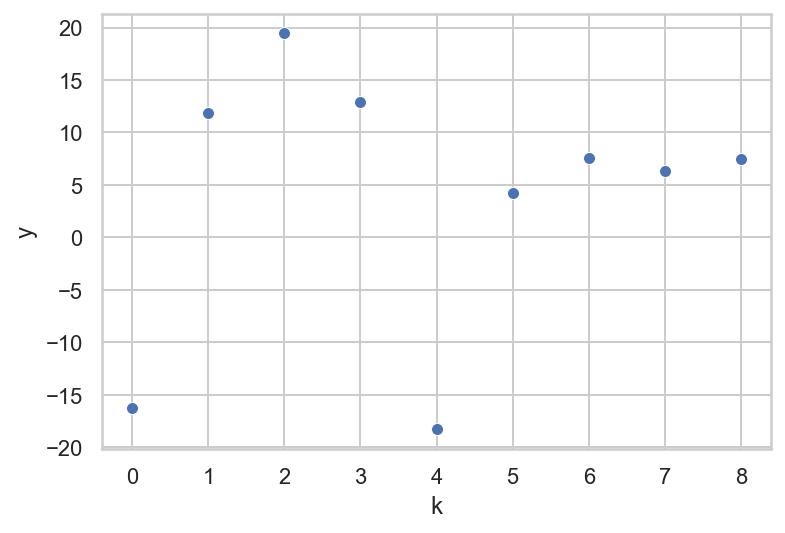

In [5]:
df = pd.DataFrame({"y": data["y"], "k": data["idx"].astype(str)})
sns.scatterplot(data=df, x="k", y="y");

#### Monolithically centered parameterization

First, we will fit a model with all of the individual parameters using the centered parameterization.
We expect there to be strong funnel degenericies because of the weakly-informed individual likelihood functions.

In [6]:
with pm.Model() as cp_model:
    mu = pm.Normal("mu", 0, 5)
    tau = pm.HalfNormal("tau", 5)
    theta = pm.Normal("theta", mu, tau, shape=data["K"])
    y = pm.Normal("y", theta[data["idx"]], data["sigma"], observed=data["y"])

    cp_trace = pm.sample(
        return_inferencedata=True, chains=4, cores=4, random_seed=RANDOM_SEED
    )
    cp_y_post_pred = pm.sample_posterior_predictive(
        trace=cp_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [7]:
az.bfmi(cp_trace)

array([0.43683752, 0.54043387, 0.50533322, 0.40669131])

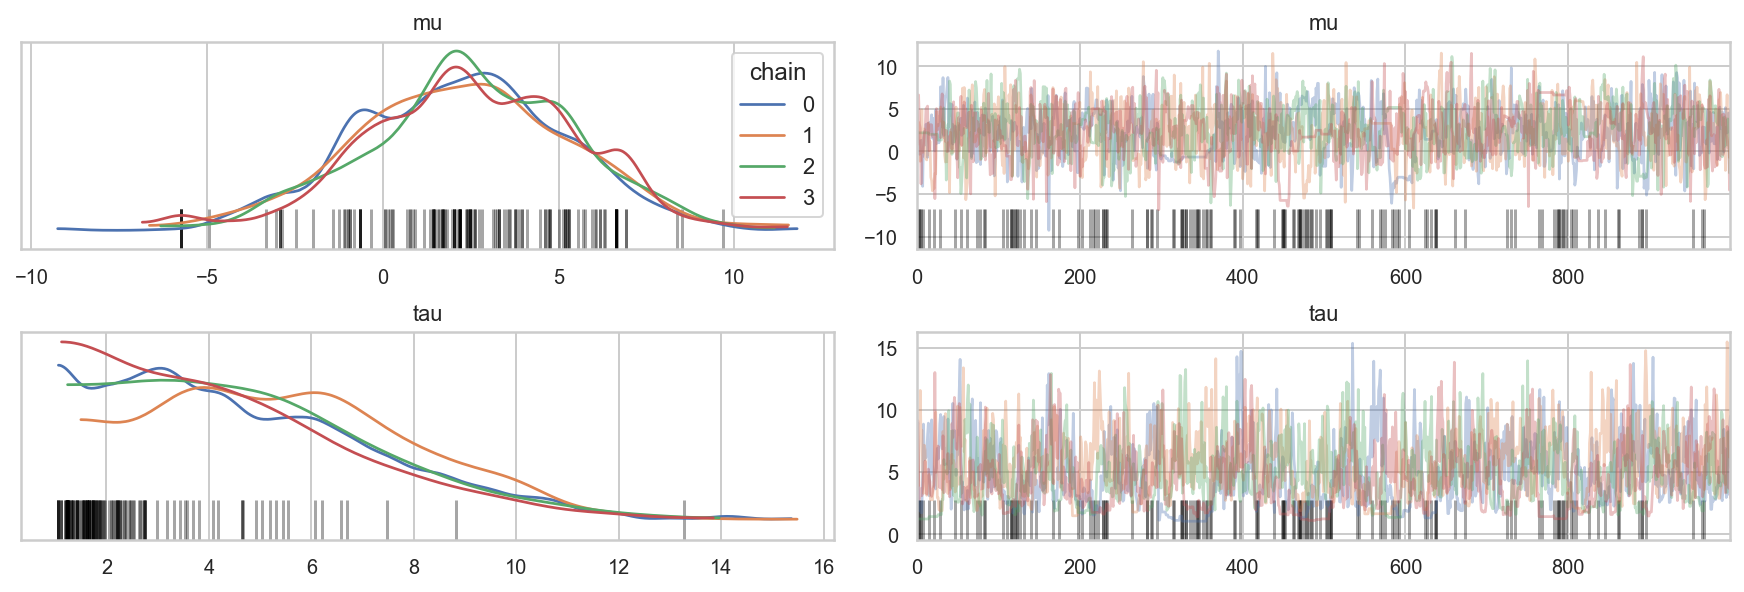

In [8]:
az.plot_trace(cp_trace, ["mu", "tau"], compact=False, combined=False, legend=True);

In [9]:
def get_divergences(t: az.InferenceData) -> np.ndarray:
    return t.sample_stats.diverging.values


def get_dispersion_and_individual_posteriors_tidy(
    t: az.InferenceData, disp_var: str, indiv_var: str, n_indiv: int
) -> pd.DataFrame:
    """Get a tidy dataframe of the dispersion posterior and individuals' posteriors.

    Args:
        t (az.InferenceData): Model trace.
        disp_var (str): Name of dispersion variable
        indiv_var (str): Name of the individual variable.
        n_indiv (int): Number of individuals.

    Returns:
        (pd.DataFrame): Tidy pandas dataframe.
    """
    divergences = get_divergences(t).flatten()
    disp_post = t.posterior[disp_var].values.flatten()
    indiv_post = t.posterior[indiv_var].values.reshape(-1, n_indiv)

    return (
        pd.concat(
            [
                pd.DataFrame(
                    {
                        disp_var: disp_post,
                        "is_divergence": divergences,
                        indiv_var: indiv_post[:, i],
                        "indiv_i": i,
                    }
                )
                for i in range(n_indiv)
            ]
        )
        .assign(_log_disp_var=lambda d: np.log(d[disp_var]))
        .rename(columns={"_log_disp_var": f"log_{disp_var}"})
    )

In [10]:
theta_tau_post_df = get_dispersion_and_individual_posteriors_tidy(
    cp_trace, "tau", "theta", data["K"]
)
theta_tau_post_df.head()

tau  is_divergence     theta  indiv_i   log_tau
0  7.843924          False -2.905894        0  2.059739
1  8.973263          False -3.000675        0  2.194249
2  2.957789          False  0.258663        0  1.084442
3  1.897426          False -3.575201        0  0.640498
4  2.459876          False  2.128138        0  0.900111

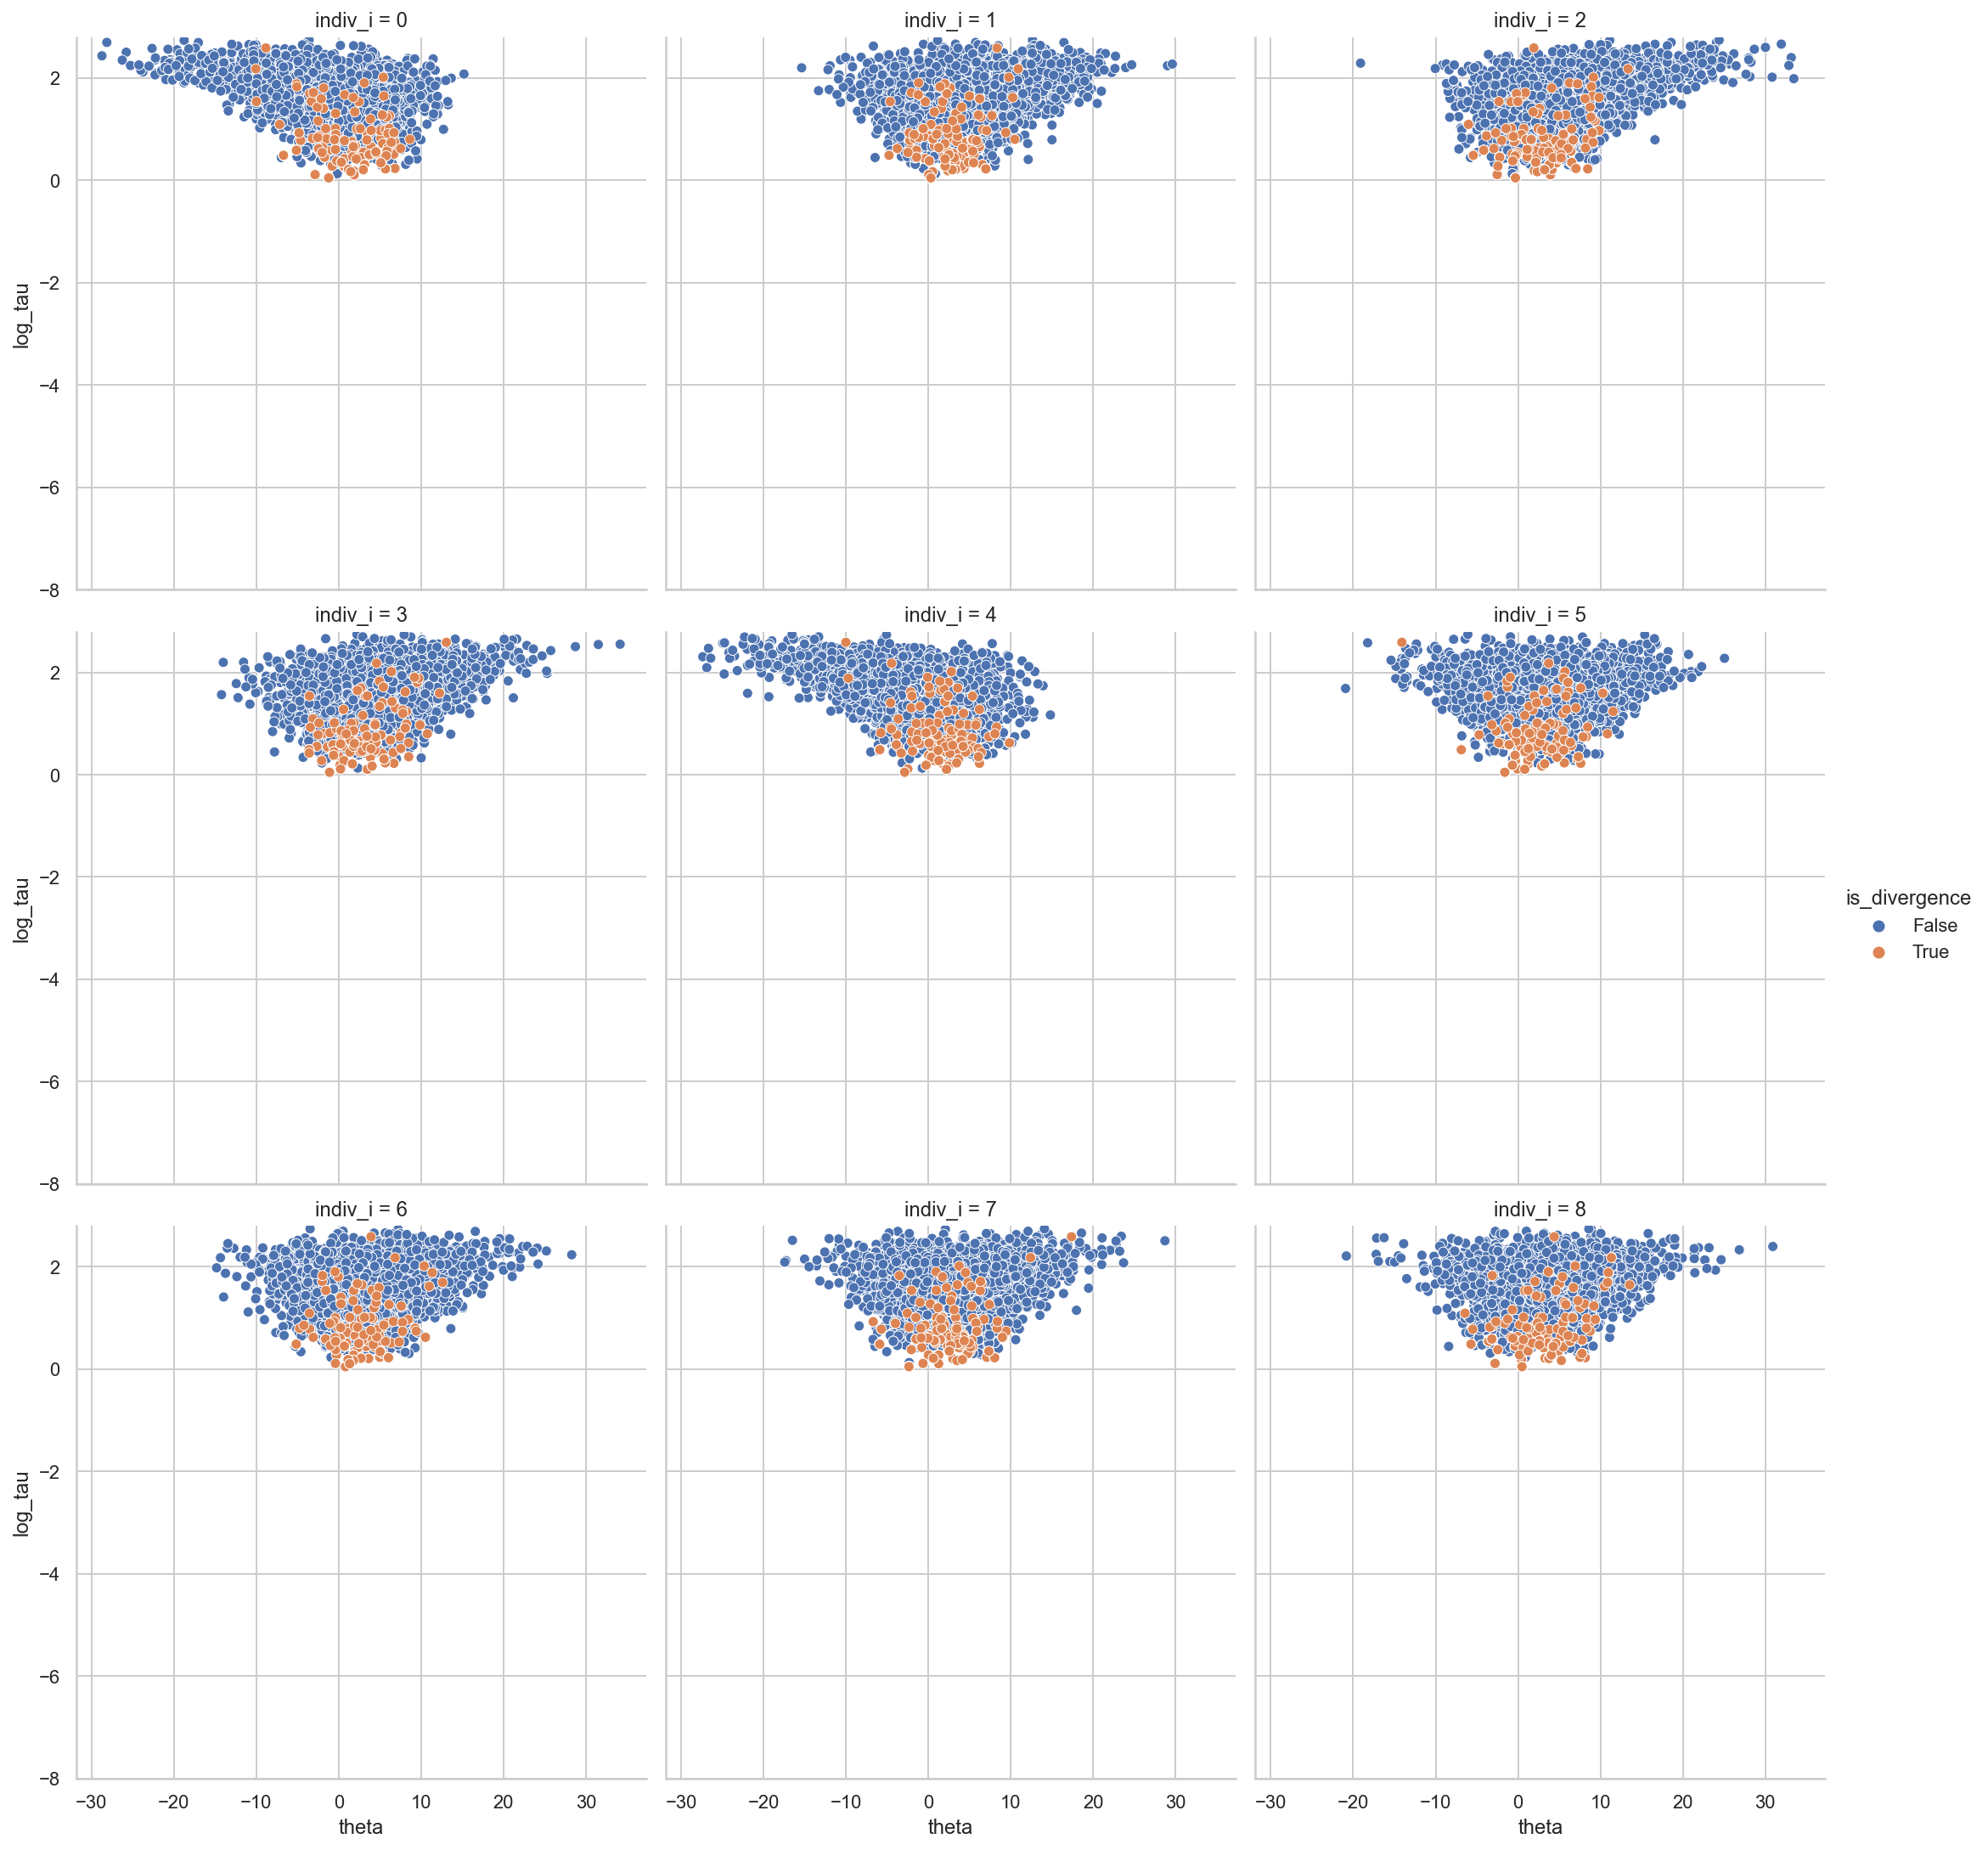

In [11]:
sns.relplot(
    data=theta_tau_post_df.sort_values("is_divergence"),
    x="theta",
    y="log_tau",
    col="indiv_i",
    hue="is_divergence",
    kind="scatter",
    col_wrap=3,
)
plt.ylim(-8, theta_tau_post_df["log_tau"].max() * 1.02)
plt.show();

#### Monolithically non-centered parameterization

The following model is a non-centered paramterization of the model.
Under these circumstances, we expect this parameterization to fix the funnel pathologices and divergeneces found in the centered paramterization.

In [12]:
with pm.Model() as ncp_model:
    mu = pm.Normal("mu", 0, 5)
    tau = pm.HalfNormal("tau", 5)
    eta = pm.Normal("eta", 0, 1, shape=data["K"])
    theta = pm.Deterministic("theta", mu + (tau * eta))
    y = pm.Normal("y", theta[data["idx"]], data["sigma"], observed=data["y"])

    ncp_trace = pm.sample(
        chains=4,
        cores=4,
        return_inferencedata=True,
        random_seed=RANDOM_SEED,
        target_accept=0.95,
    )
    ncp_y_post_pred = pm.sample_posterior_predictive(
        trace=ncp_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


In [13]:
az.bfmi(cp_trace), az.bfmi(ncp_trace)

(array([0.43683752, 0.54043387, 0.50533322, 0.40669131]),
 array([0.83273177, 0.87457   , 0.92360007, 0.97418035]))

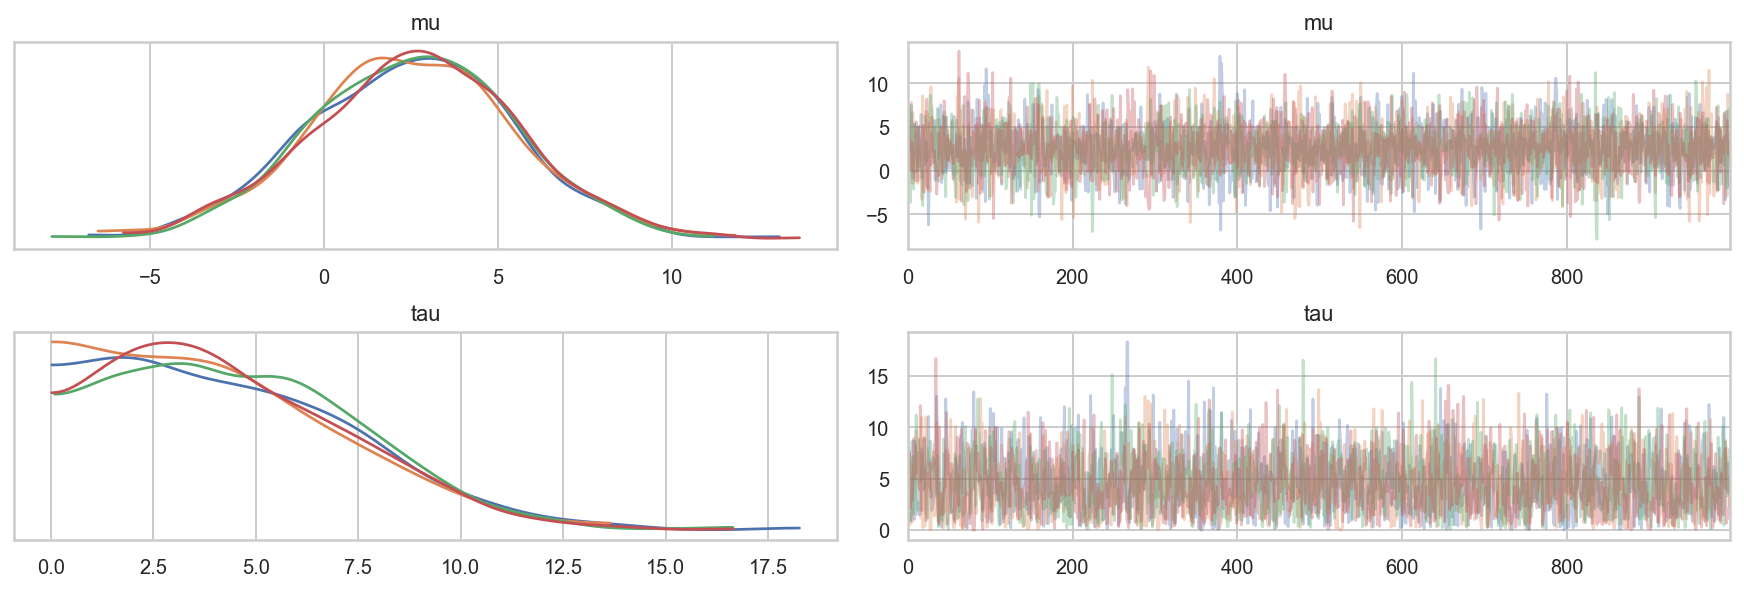

In [14]:
az.plot_trace(ncp_trace, ["mu", "tau"], compact=False, combined=False);

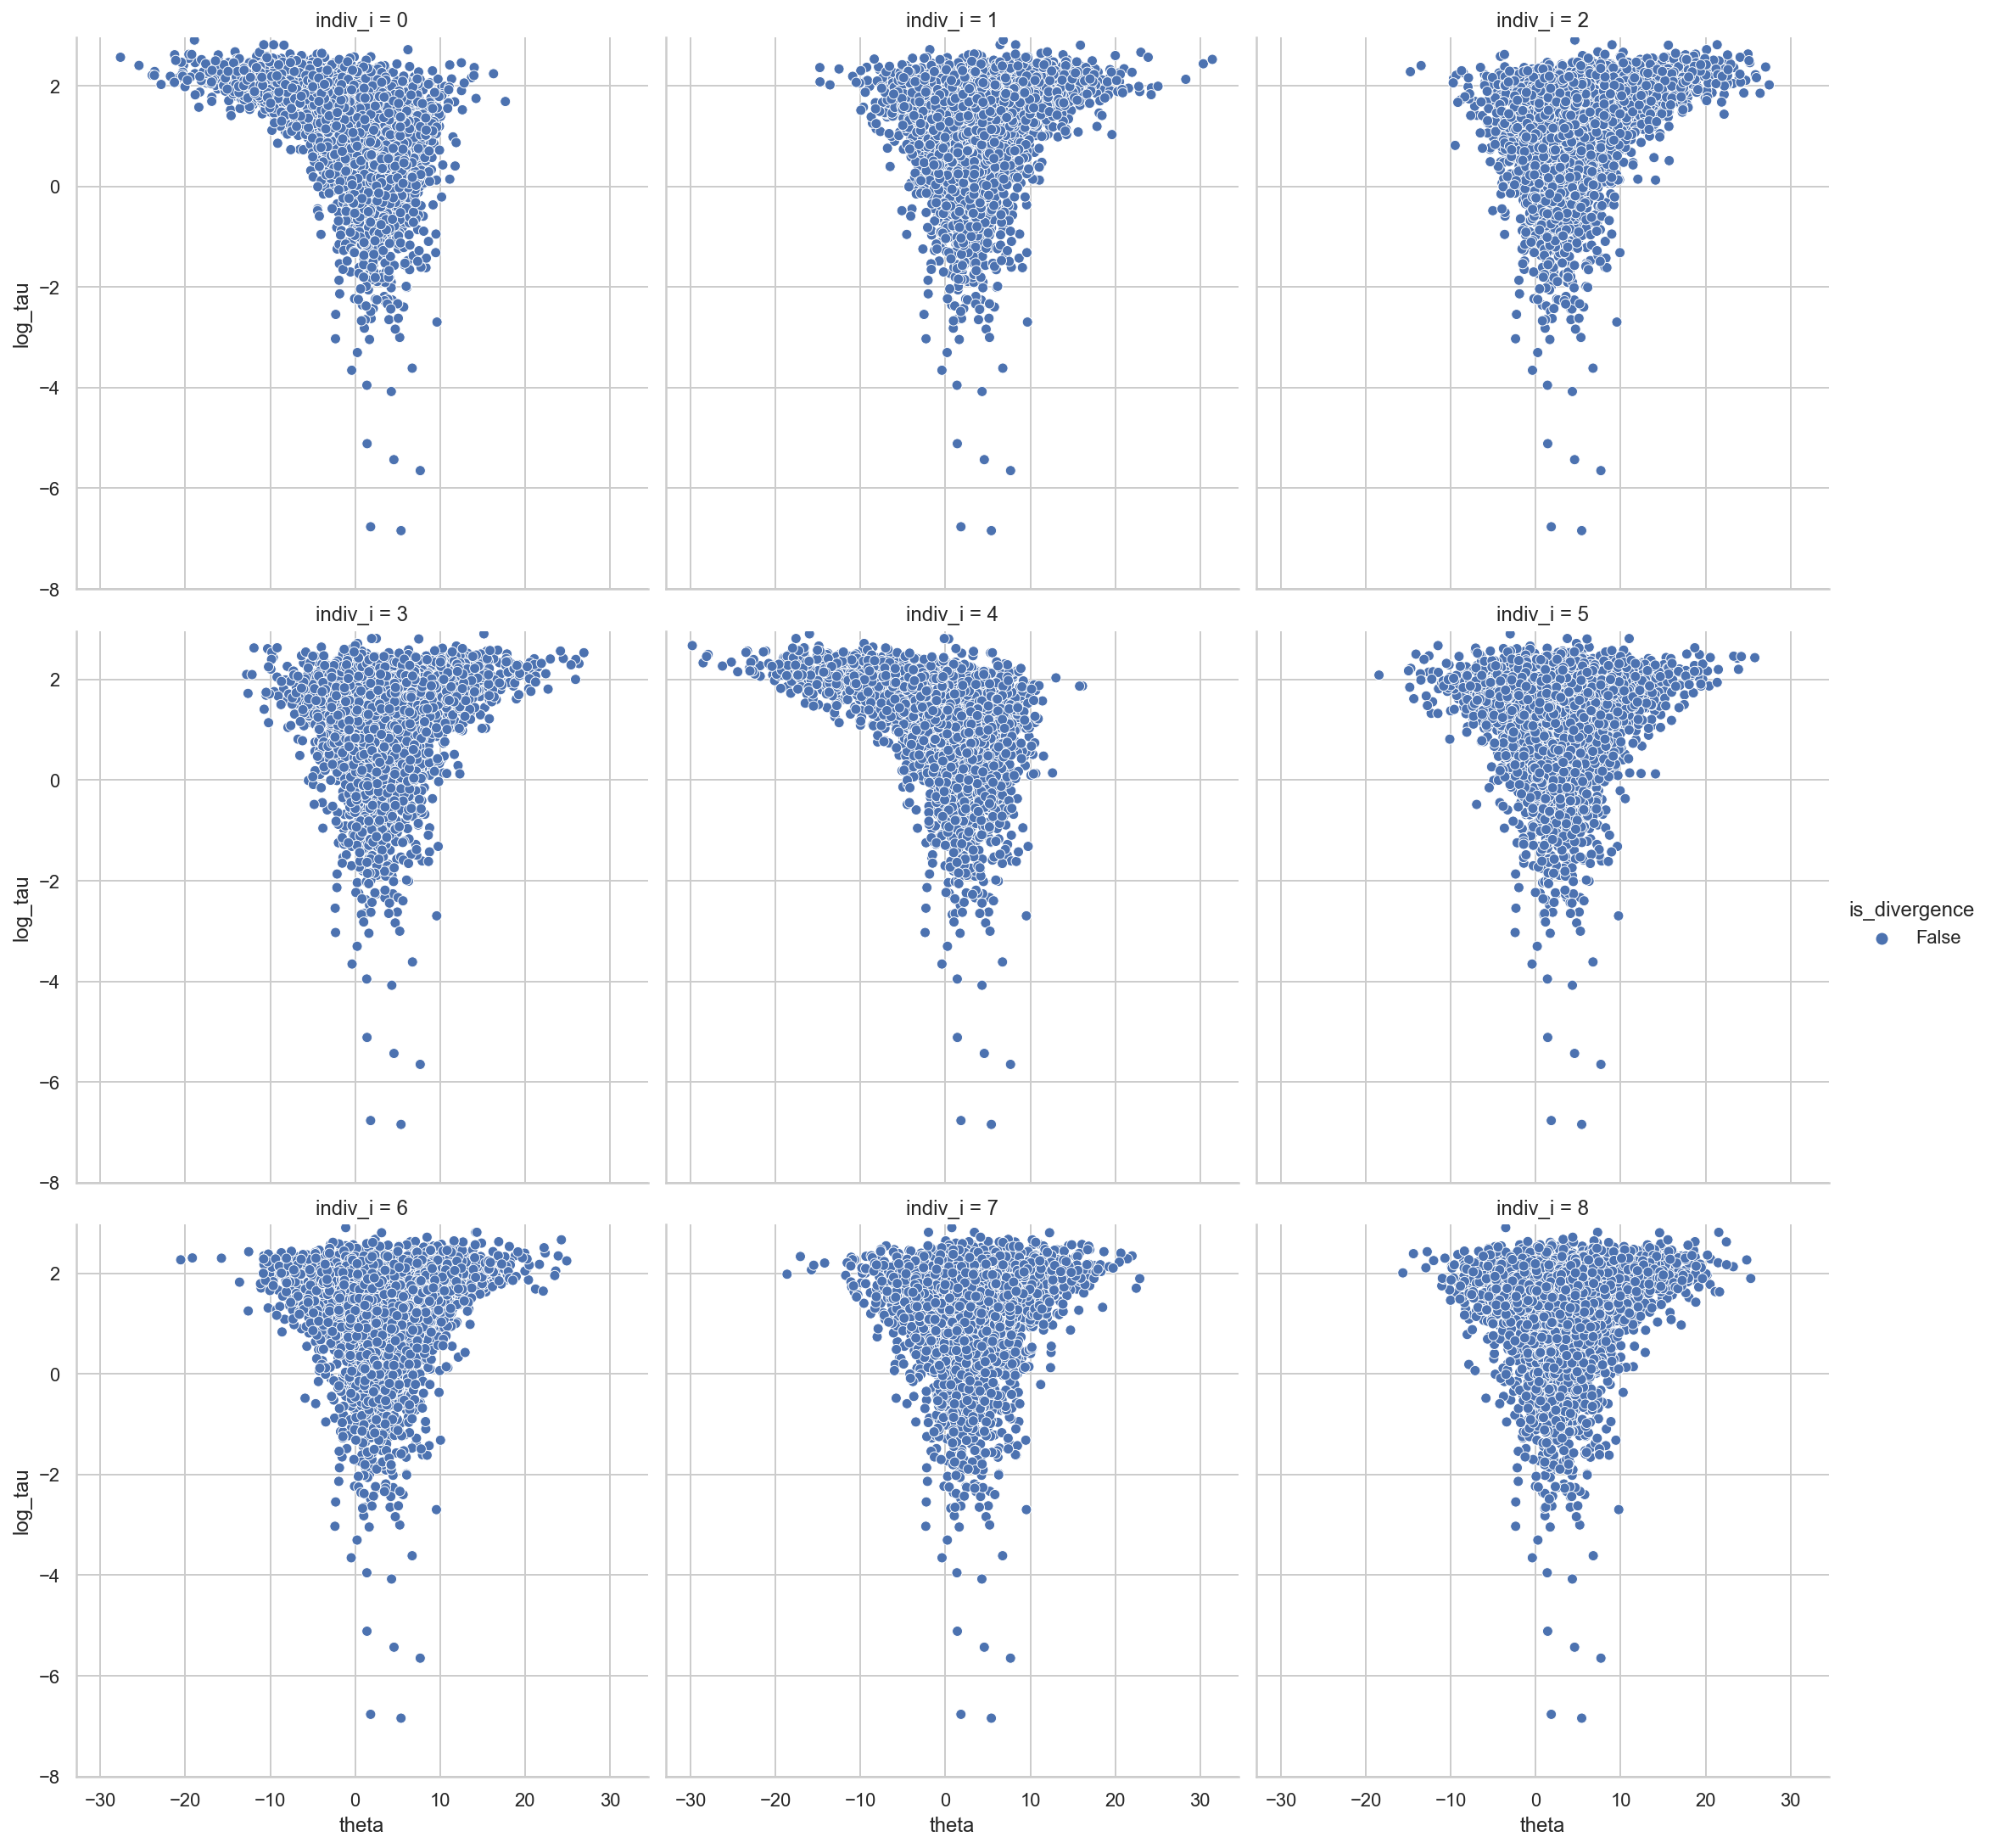

In [15]:
theta_tau_post_df_ncp = get_dispersion_and_individual_posteriors_tidy(
    ncp_trace, "tau", "theta", data["K"]
)

sns.relplot(
    data=theta_tau_post_df_ncp.sort_values("is_divergence"),
    x="theta",
    y="log_tau",
    col="indiv_i",
    hue="is_divergence",
    kind="scatter",
    col_wrap=3,
)
plt.ylim(-8, theta_tau_post_df_ncp["log_tau"].max() * 1.02)
plt.show();

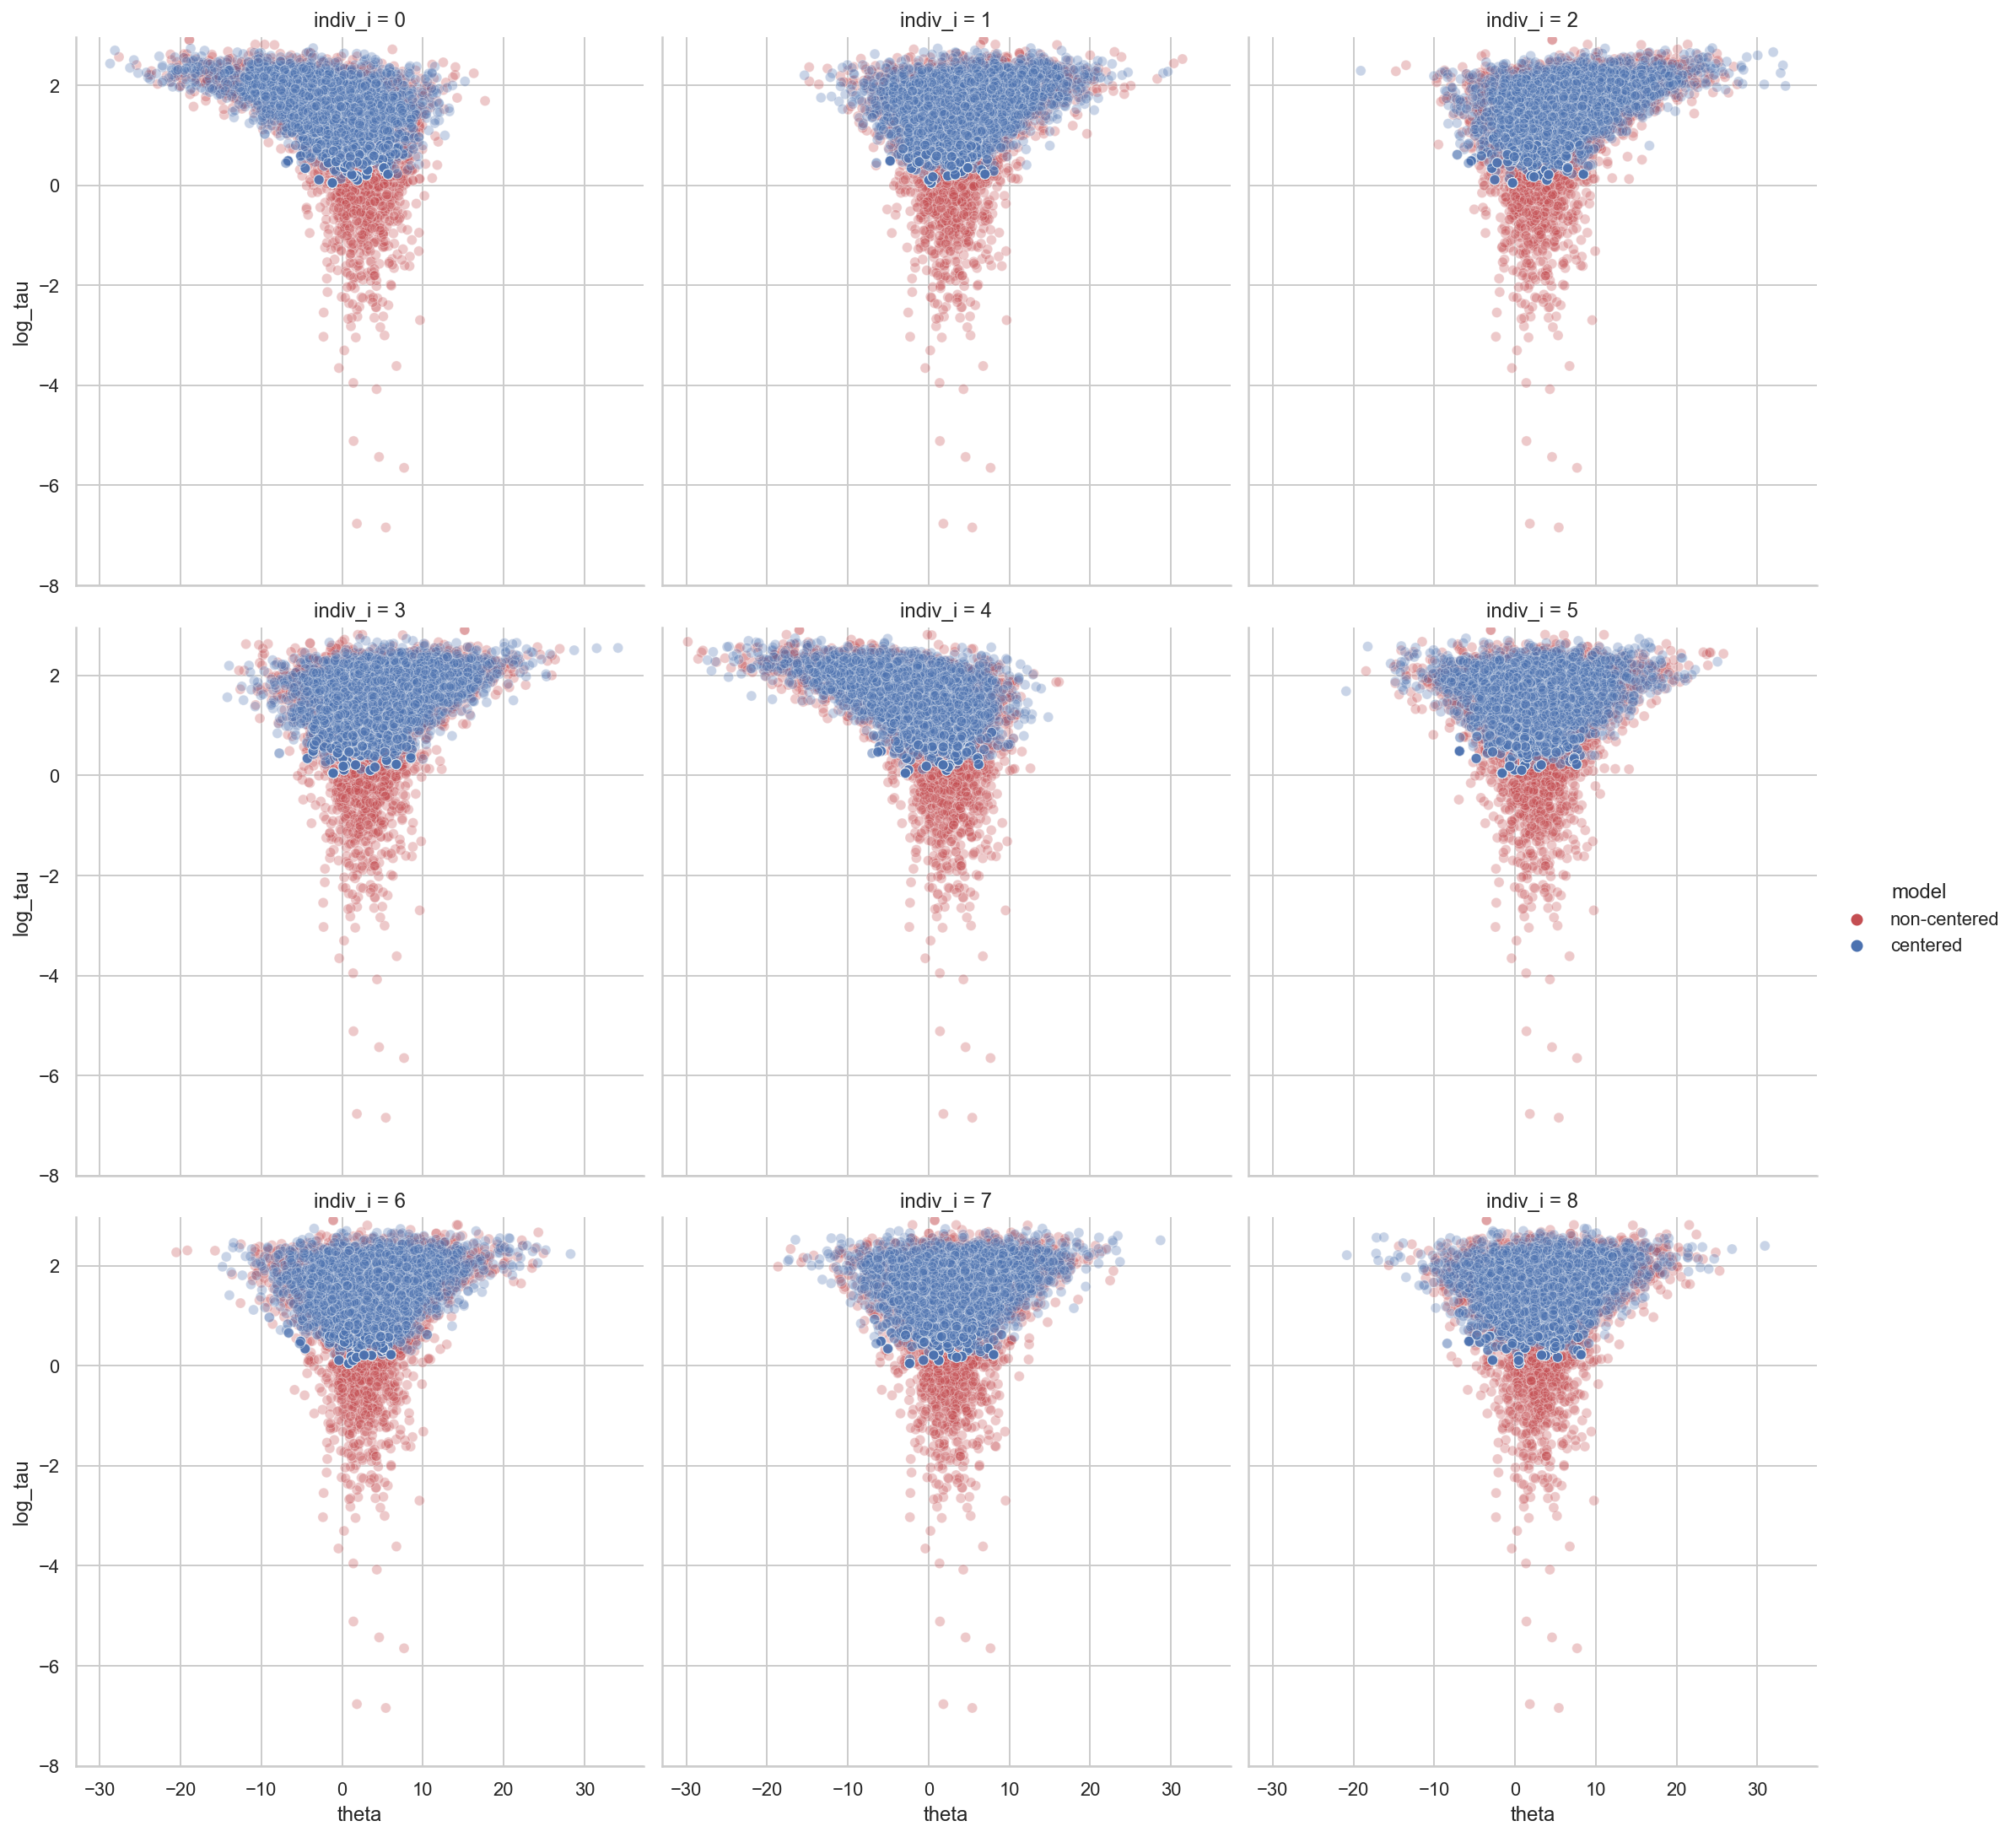

In [16]:
sns.relplot(
    data=pd.concat(
        [
            theta_tau_post_df_ncp.assign(model="non-centered"),
            theta_tau_post_df.assign(model="centered"),
        ]
    ),
    x="theta",
    y="log_tau",
    col="indiv_i",
    hue="model",
    kind="scatter",
    alpha=0.3,
    col_wrap=3,
    palette={"centered": "b", "non-centered": "r"},
)
plt.ylim(-8, theta_tau_post_df_ncp["log_tau"].max() * 1.02)
plt.show();

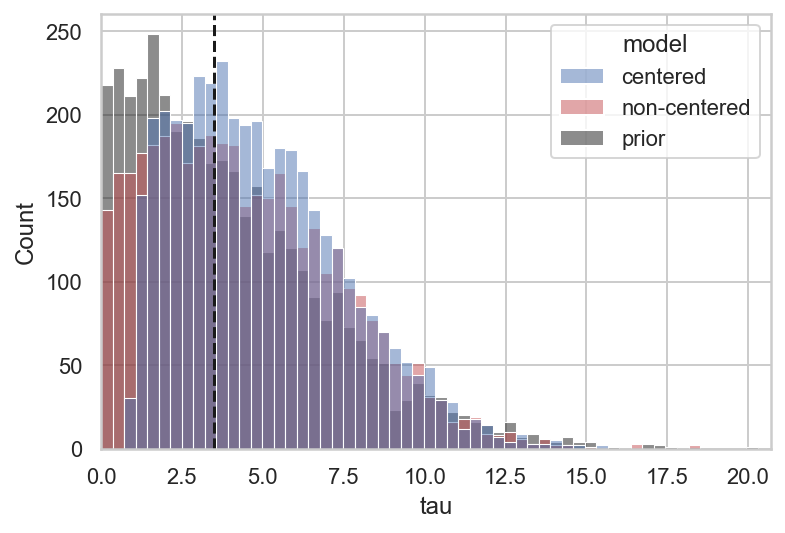

In [17]:
tau_post = pd.DataFrame(
    {
        "centered": cp_trace.posterior["tau"].values.flatten(),
        "non-centered": ncp_trace.posterior["tau"].values.flatten(),
        "prior": np.abs(np.random.normal(0, 5, 4000)),
    }
).pivot_longer(names_to="model", values_to="tau")

sns.histplot(
    data=tau_post,
    x="tau",
    hue="model",
    palette={"centered": "b", "non-centered": "r", "prior": "k"},
)
plt.xlim(0, tau_post.tau.max() * 1.02)
plt.axvline(data["tau"], color="k", linestyle="--")
plt.show();

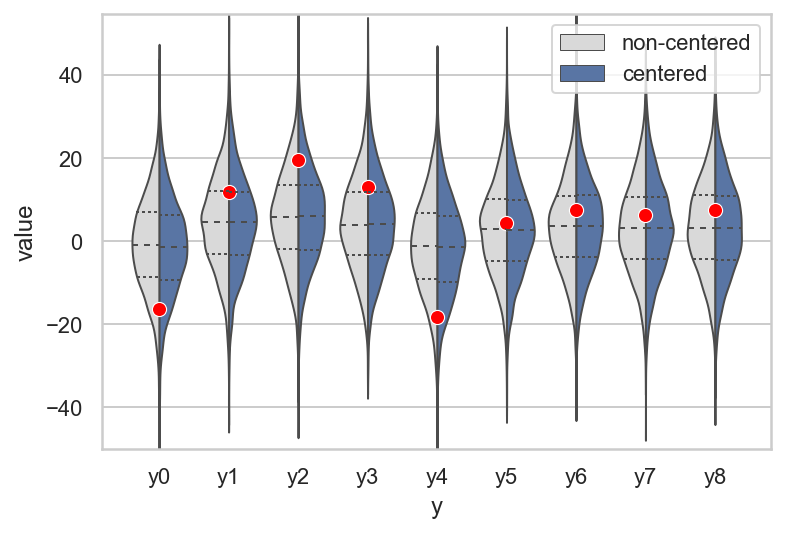

In [18]:
ppc_df = pd.DataFrame()

for ppc, model in zip([ncp_y_post_pred, cp_y_post_pred], ["non-centered", "centered"]):
    df = pd.DataFrame(ppc["y"])
    df.columns = [f"y{i}" for i in df.columns]
    df = df.pivot_longer(names_to="y", values_to="value").assign(model=model)
    ppc_df = pd.concat([ppc_df, df])

data_df = pd.DataFrame({"y": [f"y{i}" for i in range(data["K"])], "value": data["y"]})

sns.set_theme(style="whitegrid")
ax = sns.violinplot(
    data=ppc_df,
    x="y",
    y="value",
    hue="model",
    split=True,
    inner="quart",
    linewidth=1,
    palette={"centered": "b", "non-centered": ".85"},
)
ax = sns.scatterplot(data=data_df, x="y", y="value", ax=ax, color="red", s=50)
plt.ylim(ppc_df.value.min(), ppc_df.value.max())
plt.show()

### Uniformally strongly-informative likelihood functions 

Now we will look at a case where there individual likelihoods are close enough to dominate the structure of the posterior density function.
The data will now be generated with a smaller standard deviation, $\sigma = 0.1$.

In [19]:
np.random.seed(1235)
data = generate_data(N=N, K=K, indiv_idx=indiv_idx, sigma=0.1)
pprint(data)

{'K': 9,
 'N': 9,
 'idx': array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 'mu': 4.5,
 'sigma': 0.1,
 'tau': 3.5,
 'theta': array([ 6.91283813,  4.38900749,  6.83818764,  6.21093237,  2.12074111,
       -0.07617784,  9.64606529,  0.19140465,  7.85571339]),
 'y': array([ 6.98688709,  4.45933654,  6.83083539,  6.08350102,  2.09762541,
       -0.02566351,  9.69733848,  0.32184067,  7.92877661])}


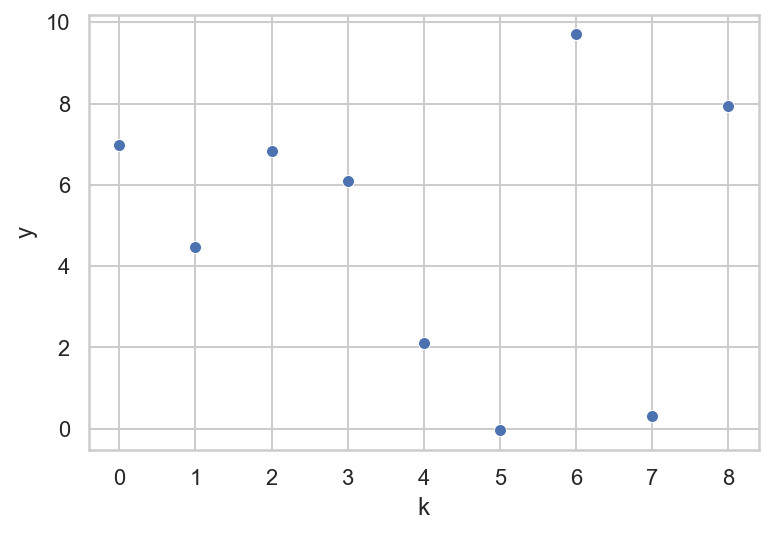

In [20]:
df = pd.DataFrame({"y": data["y"], "k": data["idx"].astype(str)})
sns.scatterplot(data=df, x="k", y="y");

#### Monolithically centered parameterization

First, we will fit a model with all of the individual parameters using the centered parameterization.
With the more informative individual likelihoods, we expect this model to perform well.

In [21]:
with pm.Model() as cp_model:
    mu = pm.Normal("mu", 0, 5)
    tau = pm.HalfNormal("tau", 5)
    theta = pm.Normal("theta", mu, tau, shape=data["K"])
    y = pm.Normal("y", theta[data["idx"]], data["sigma"], observed=data["y"])

    cp_trace = pm.sample(
        chains=4, cores=4, return_inferencedata=True, random_seed=RANDOM_SEED
    )
    cp_y_post_pred = pm.sample_posterior_predictive(
        trace=cp_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [22]:
az.bfmi(cp_trace)

array([1.15776615, 1.11888735, 1.16216315, 1.11394339])

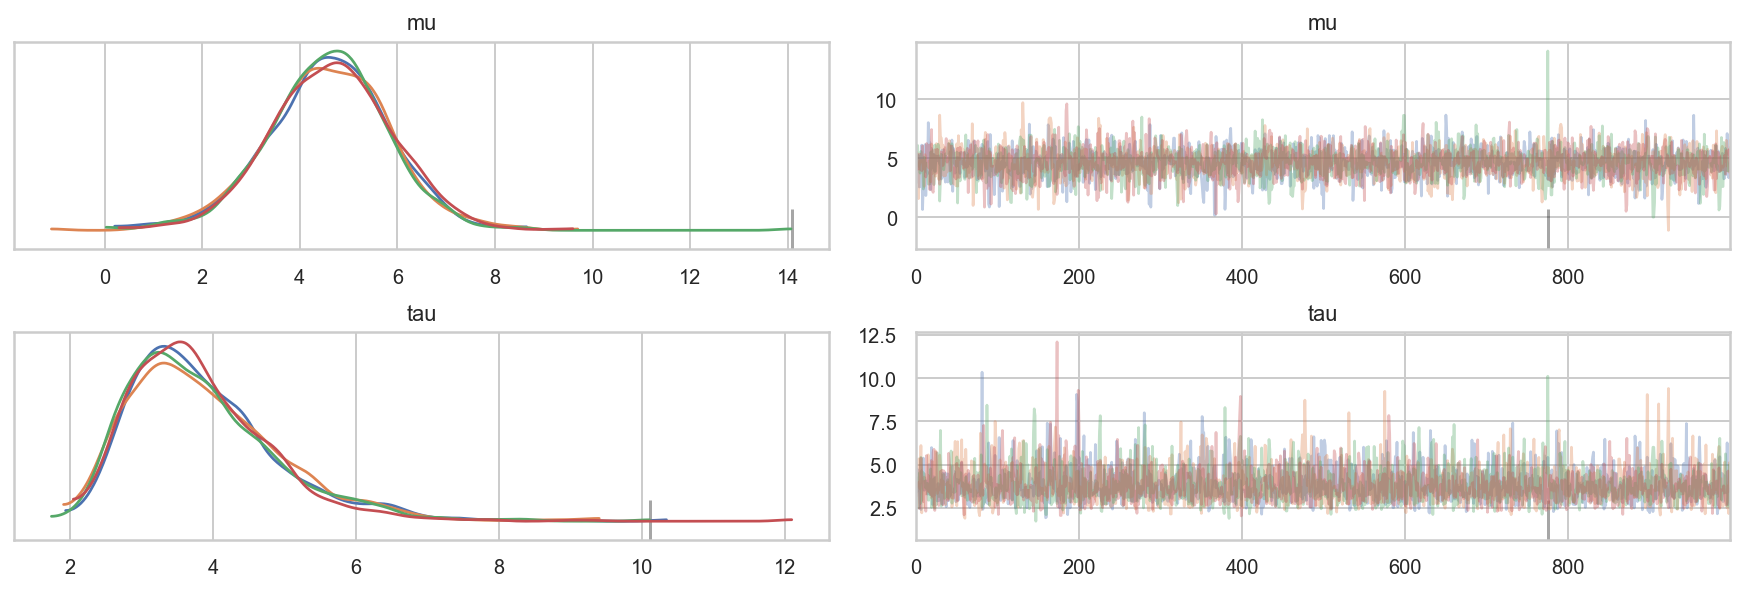

In [23]:
az.plot_trace(cp_trace, ["mu", "tau"], compact=False, combined=False);

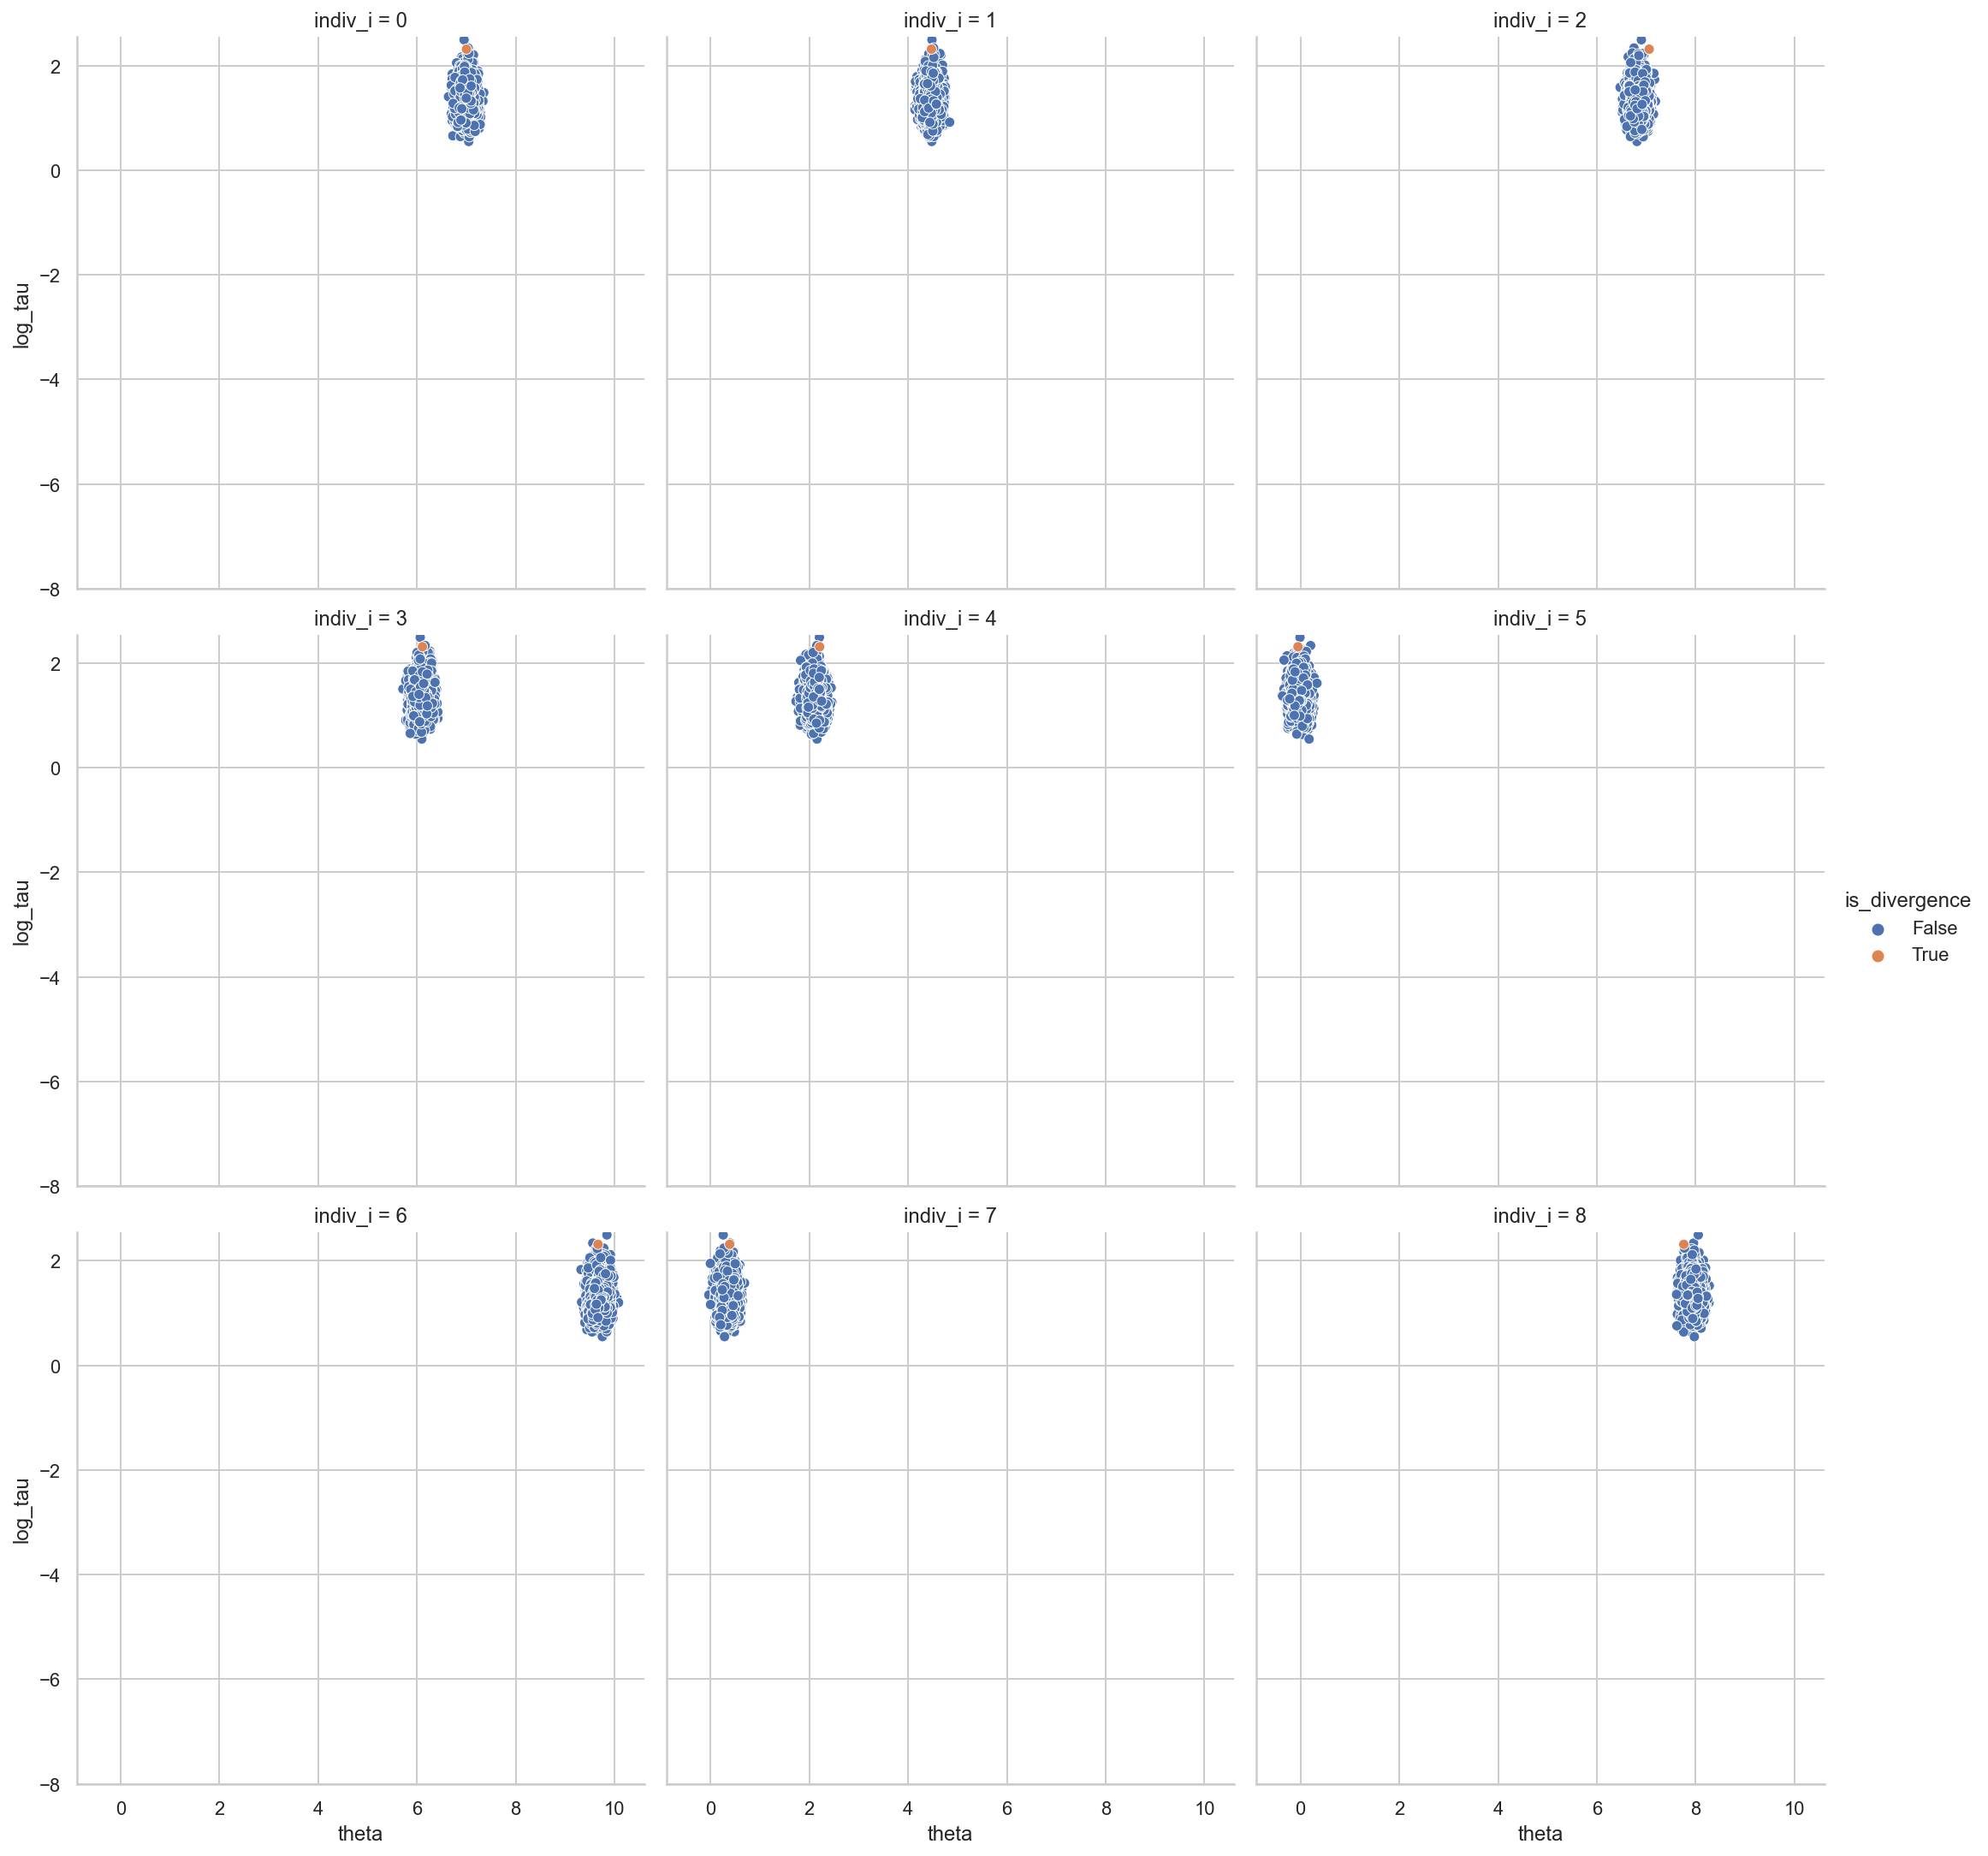

In [24]:
theta_tau_post_df = get_dispersion_and_individual_posteriors_tidy(
    cp_trace, "tau", "theta", data["K"]
)

sns.relplot(
    data=theta_tau_post_df.sort_values("is_divergence"),
    x="theta",
    y="log_tau",
    col="indiv_i",
    hue="is_divergence",
    kind="scatter",
    col_wrap=3,
)
plt.ylim(-8, theta_tau_post_df["log_tau"].max() * 1.02)
plt.show();

In [25]:
with pm.Model() as ncp_model:
    mu = pm.Normal("mu", 0, 5)
    tau = pm.HalfNormal("tau", 5)
    eta = pm.Normal("eta", 0, 1, shape=data["K"])
    theta = pm.Deterministic("theta", mu + (tau * eta))
    y = pm.Normal("y", theta[data["idx"]], data["sigma"], observed=data["y"])

    ncp_trace = pm.sample(
        chains=4,
        cores=4,
        return_inferencedata=True,
        random_seed=RANDOM_SEED,
        target_accept=0.95,
    )
    ncp_y_post_pred = pm.sample_posterior_predictive(
        trace=ncp_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [26]:
az.bfmi(cp_trace), az.bfmi(ncp_trace)

(array([1.15776615, 1.11888735, 1.16216315, 1.11394339]),
 array([0.87013016, 0.74180415, 0.87593667, 0.8008909 ]))

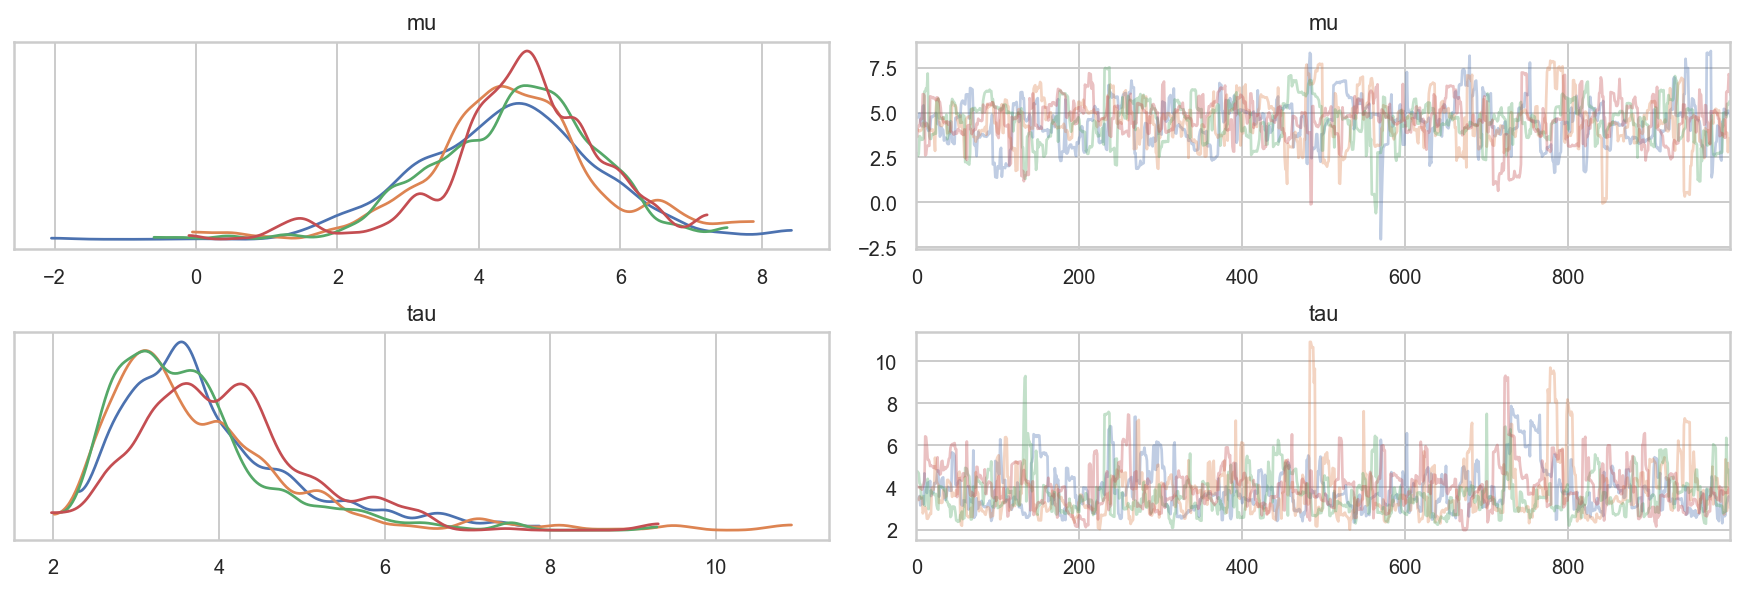

In [27]:
az.plot_trace(ncp_trace, ["mu", "tau"], compact=False, combined=False);

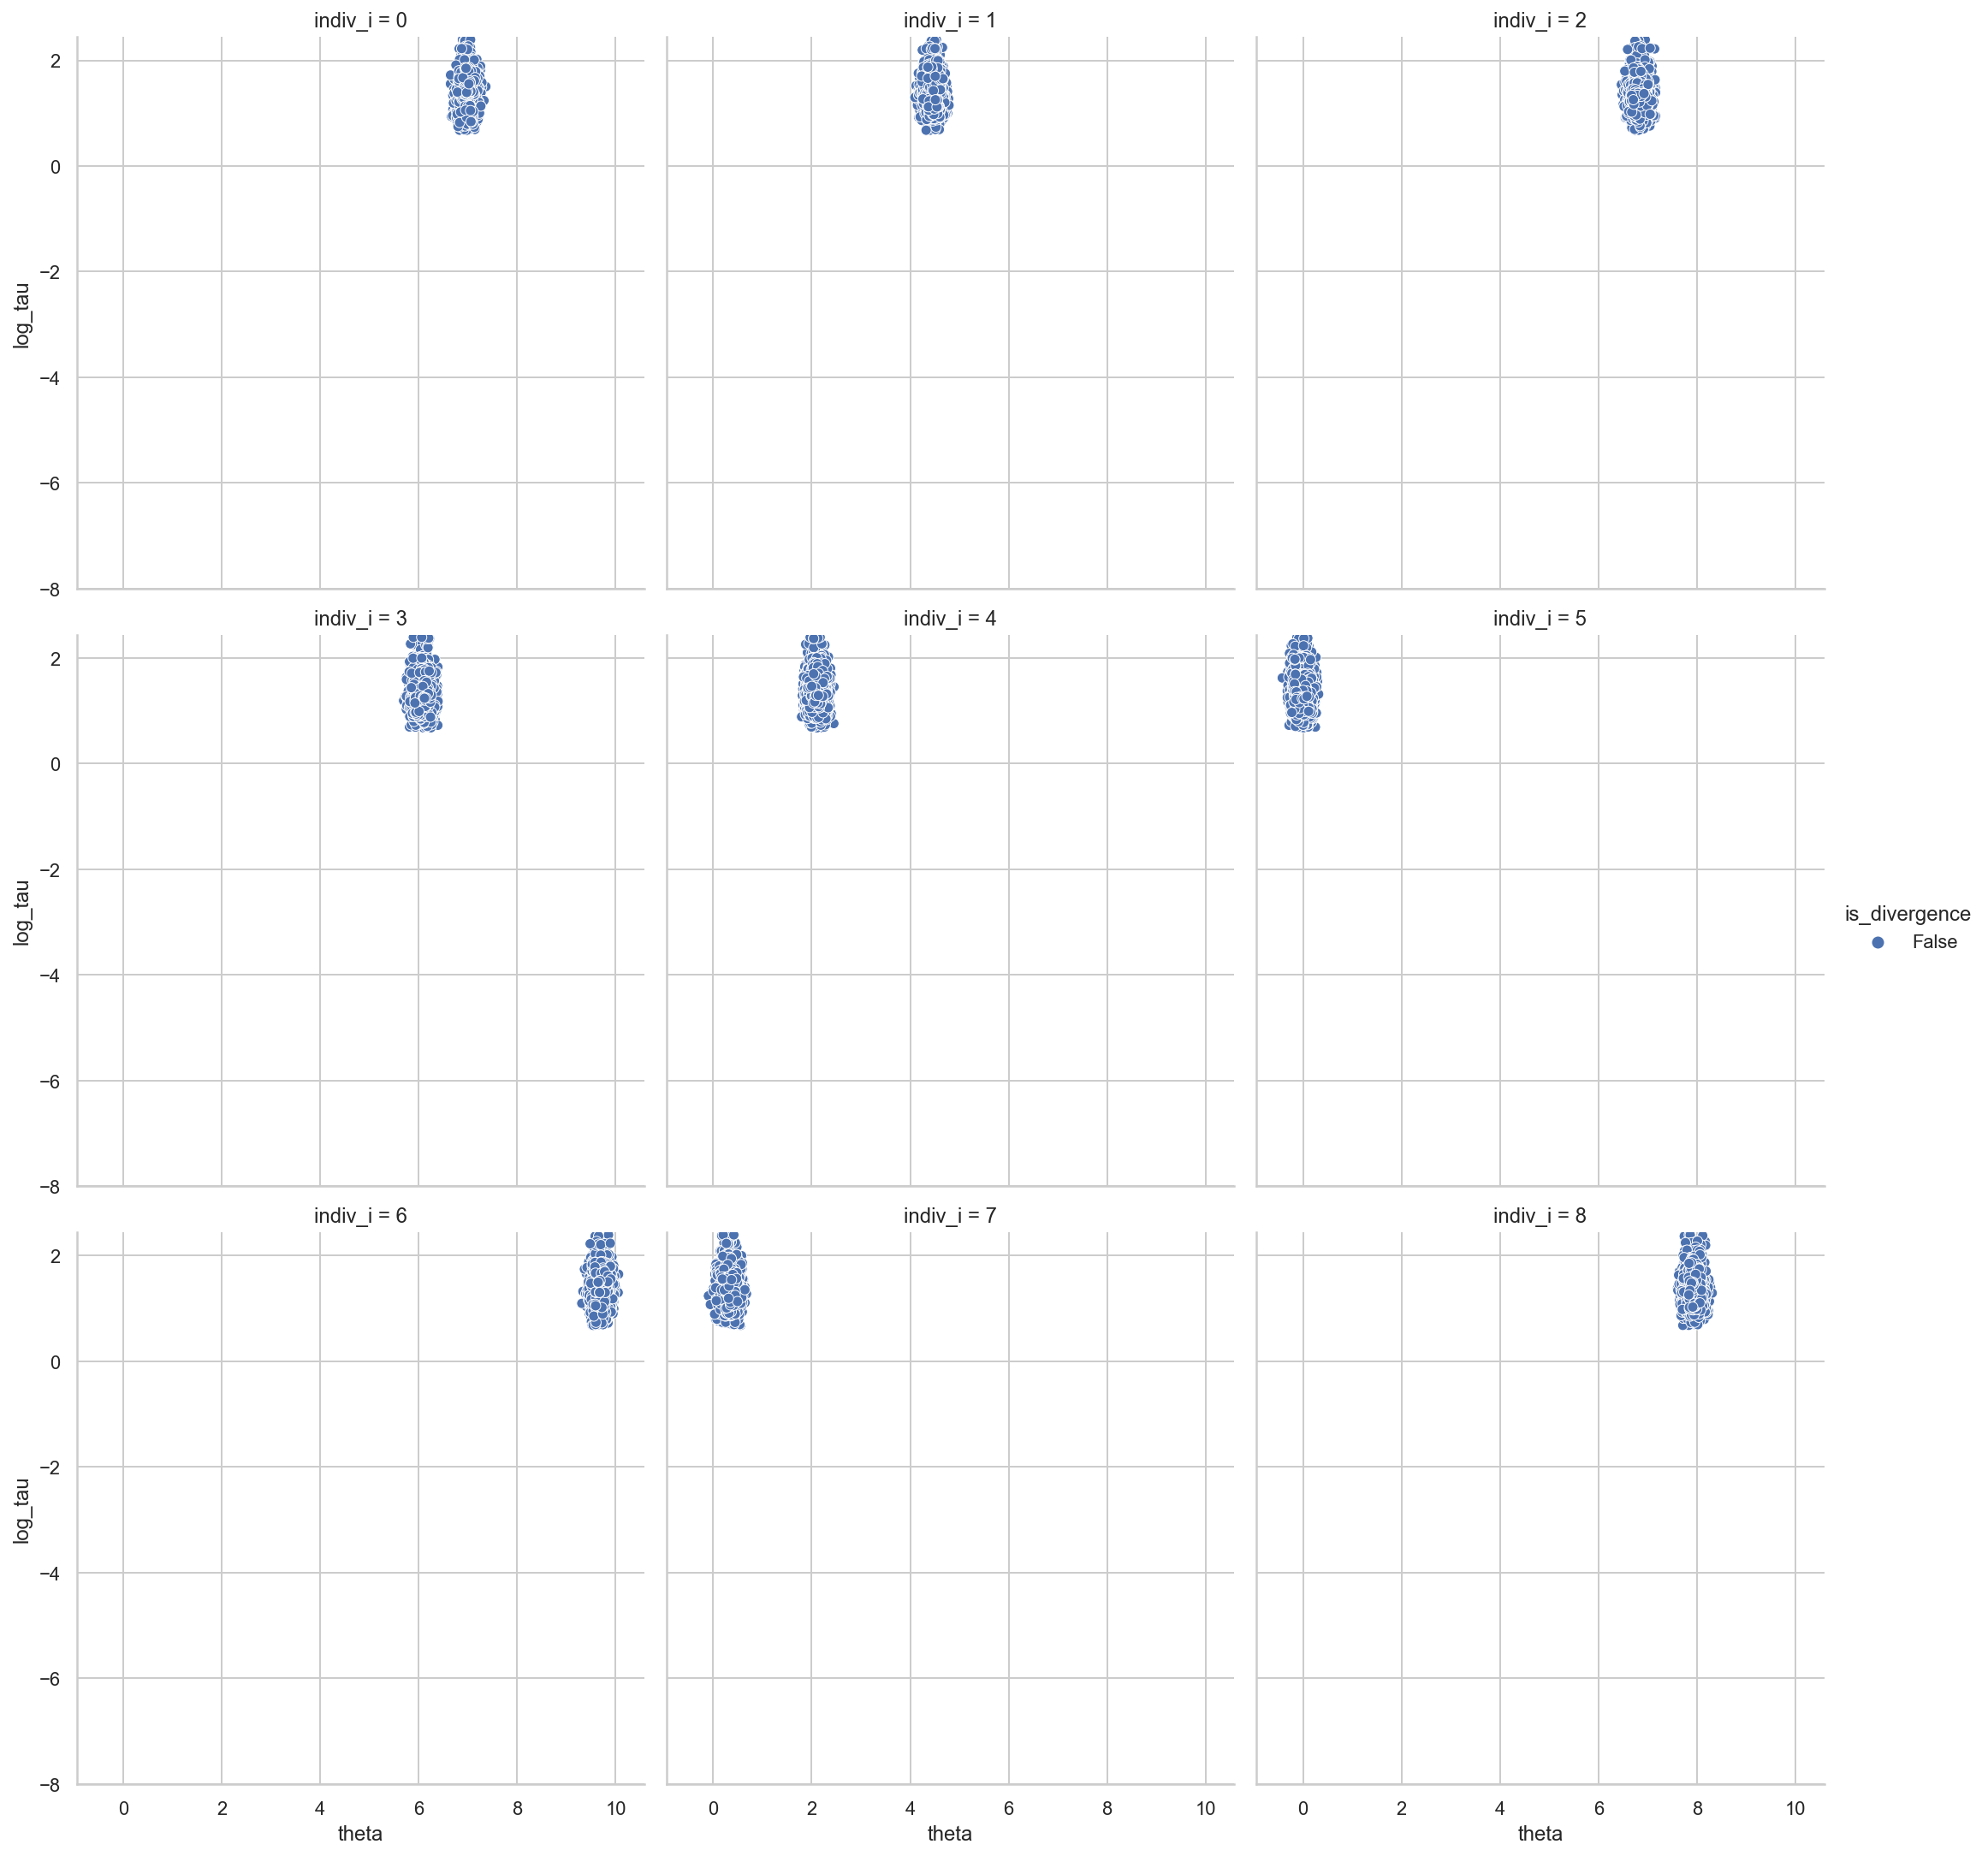

In [28]:
theta_tau_post_df_ncp = get_dispersion_and_individual_posteriors_tidy(
    ncp_trace, "tau", "theta", data["K"]
)

sns.relplot(
    data=theta_tau_post_df_ncp.sort_values("is_divergence"),
    x="theta",
    y="log_tau",
    col="indiv_i",
    hue="is_divergence",
    kind="scatter",
    col_wrap=3,
)
plt.ylim(-8, theta_tau_post_df_ncp["log_tau"].max() * 1.02)
plt.show();

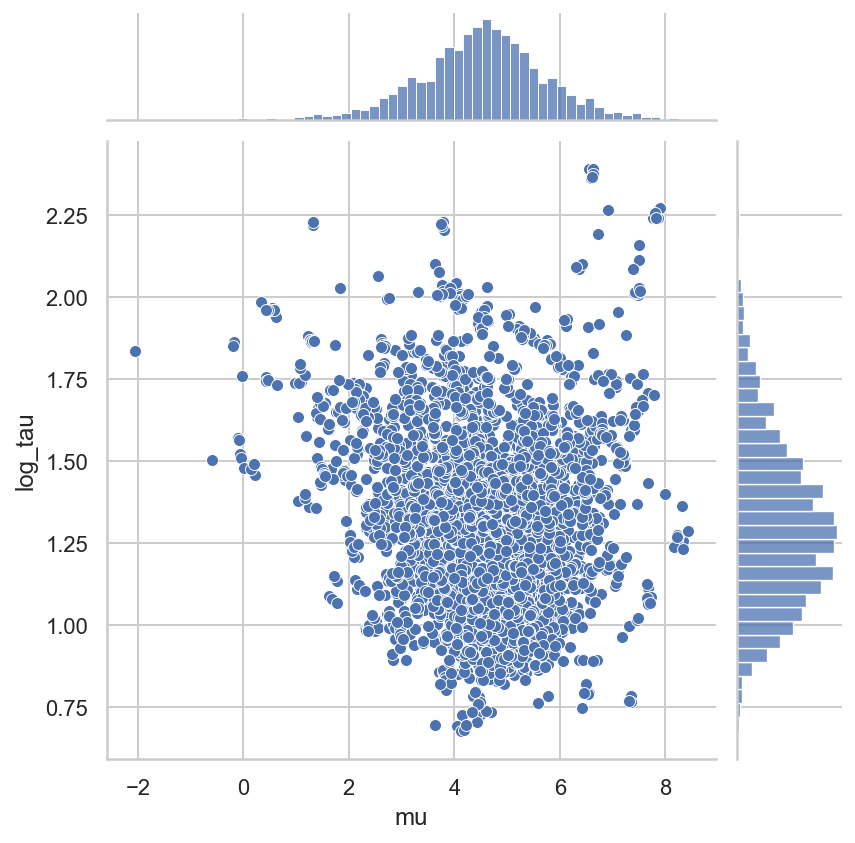

In [29]:
ncp_population_post = pd.DataFrame(
    {v: ncp_trace.posterior[v].values.flatten() for v in ["mu", "tau"]}
).assign(log_tau=lambda d: np.log(d.tau))
sns.jointplot(data=ncp_population_post, x="mu", y="log_tau");

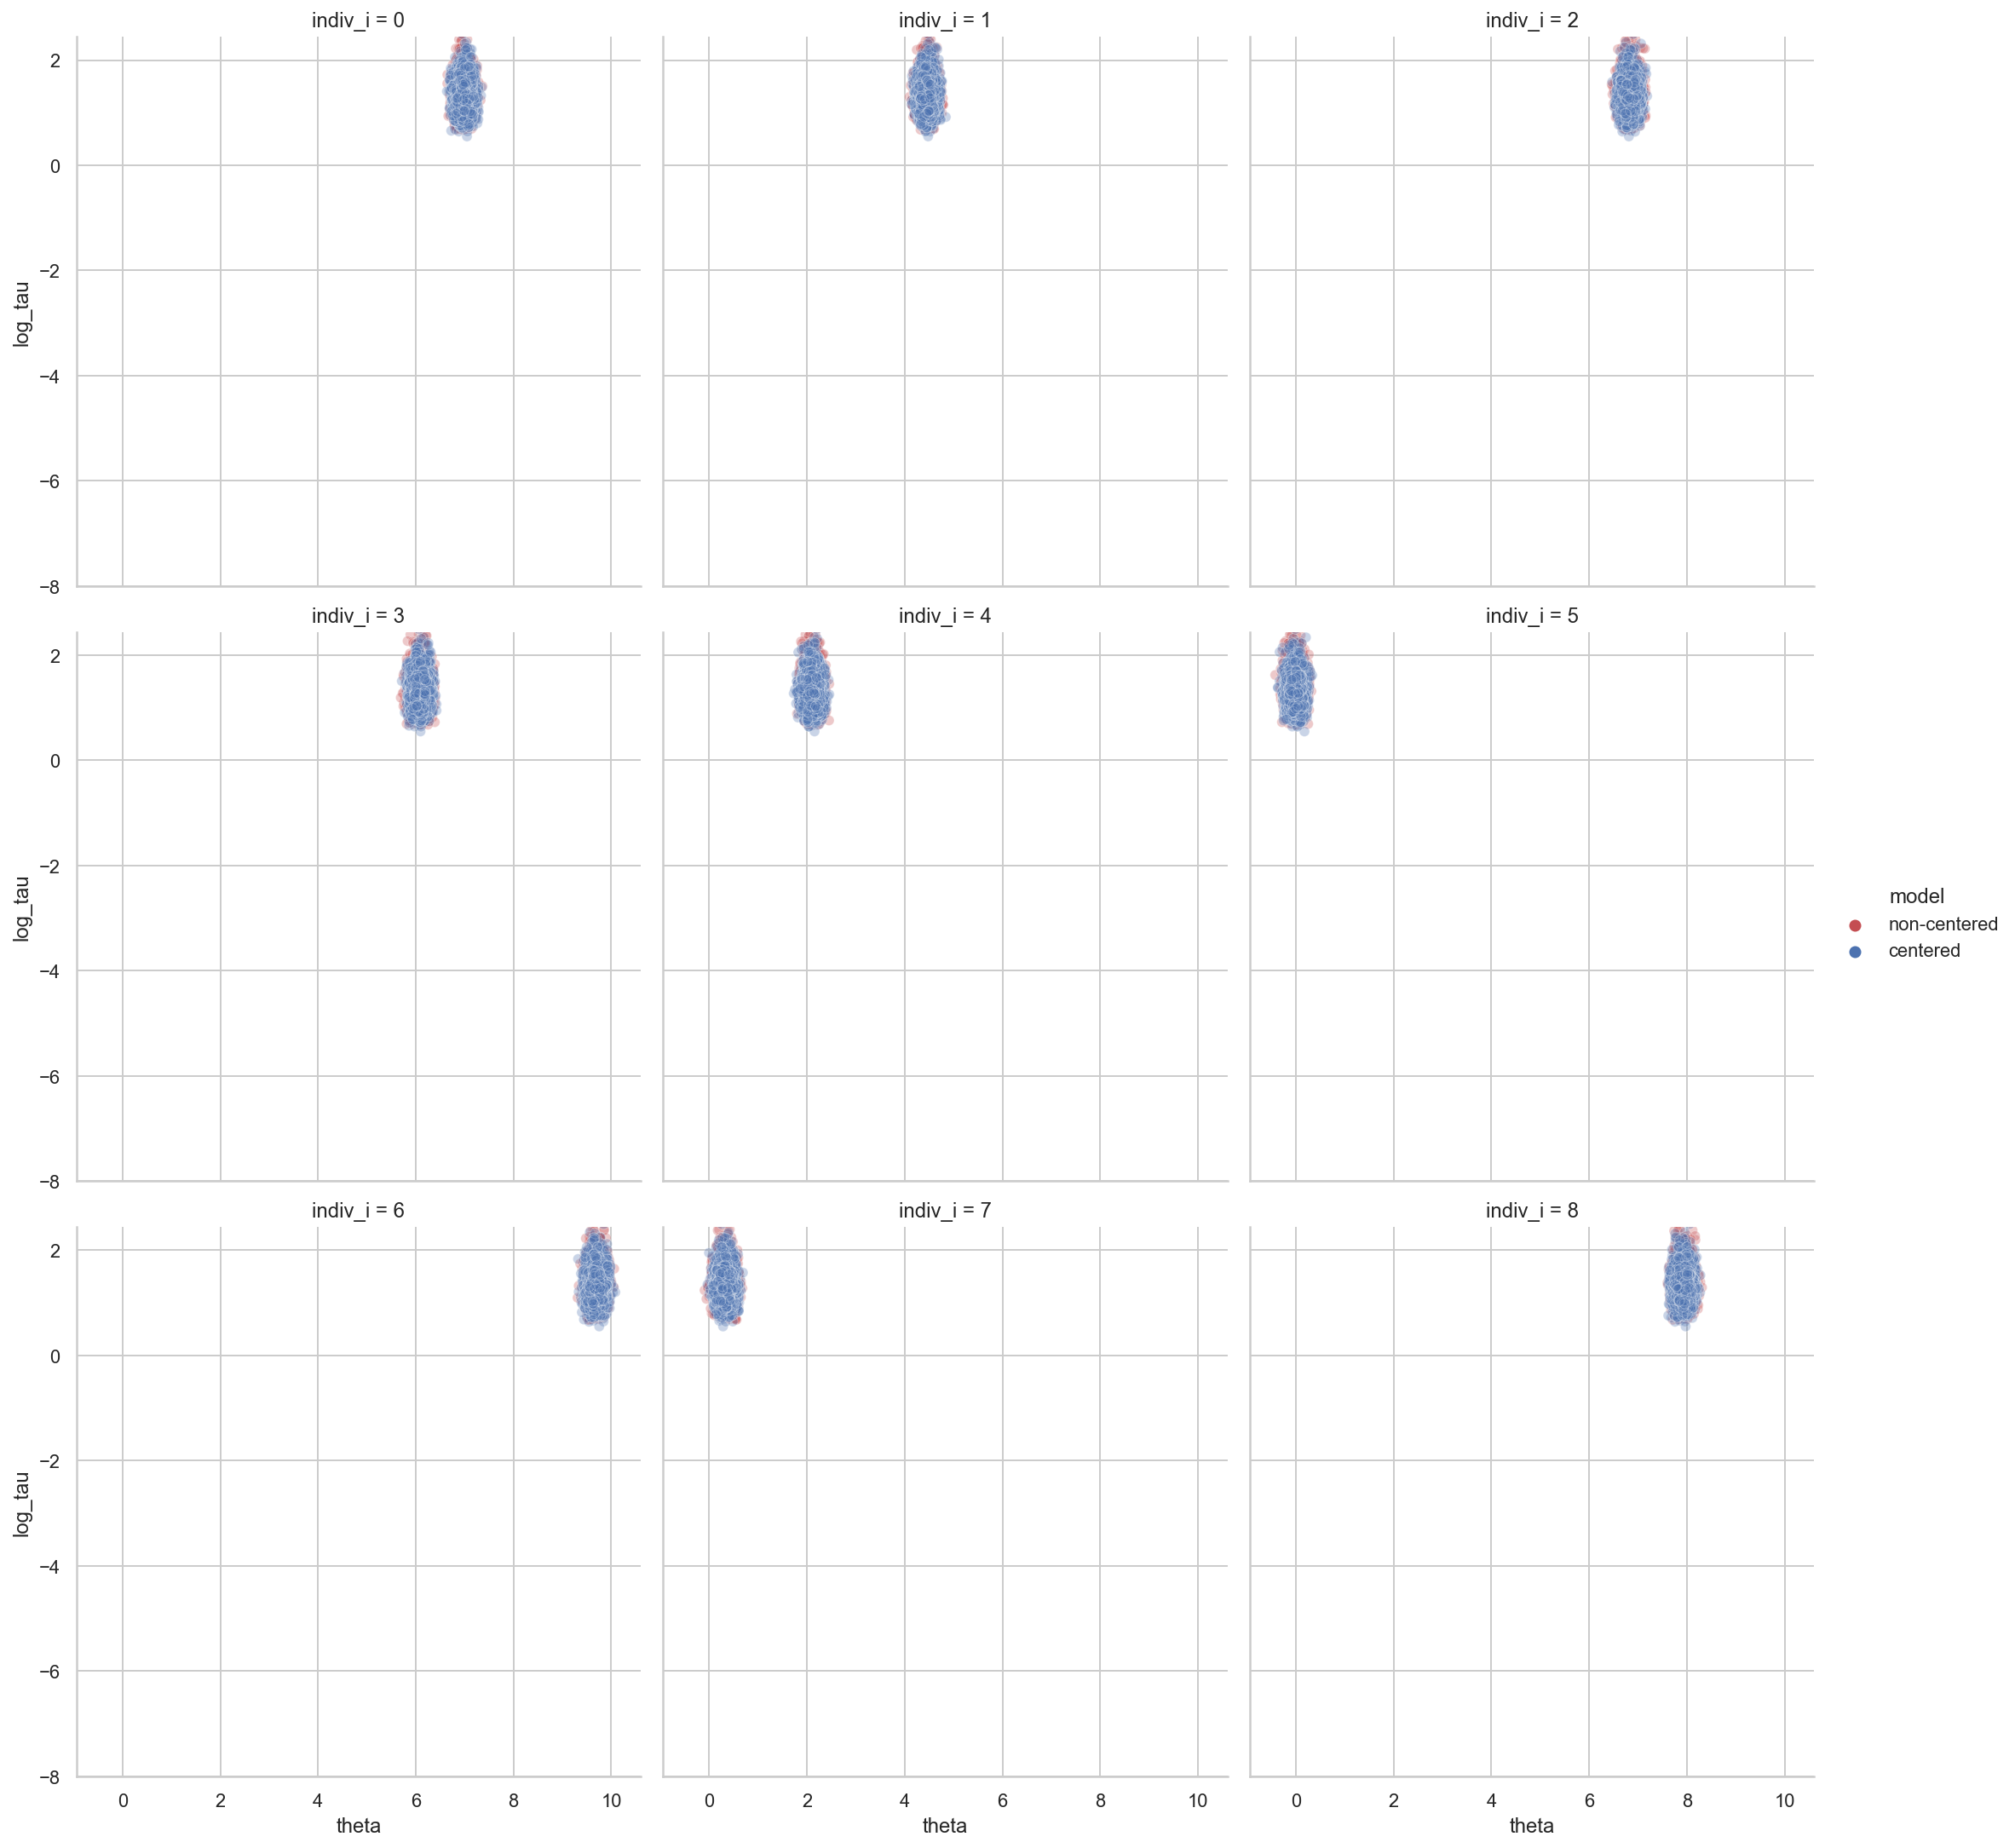

In [30]:
sns.relplot(
    data=pd.concat(
        [
            theta_tau_post_df_ncp.assign(model="non-centered"),
            theta_tau_post_df.assign(model="centered"),
        ]
    ),
    x="theta",
    y="log_tau",
    col="indiv_i",
    hue="model",
    kind="scatter",
    alpha=0.3,
    col_wrap=3,
    palette={"centered": "b", "non-centered": "r"},
)
plt.ylim(-8, theta_tau_post_df_ncp["log_tau"].max() * 1.02)
plt.show();

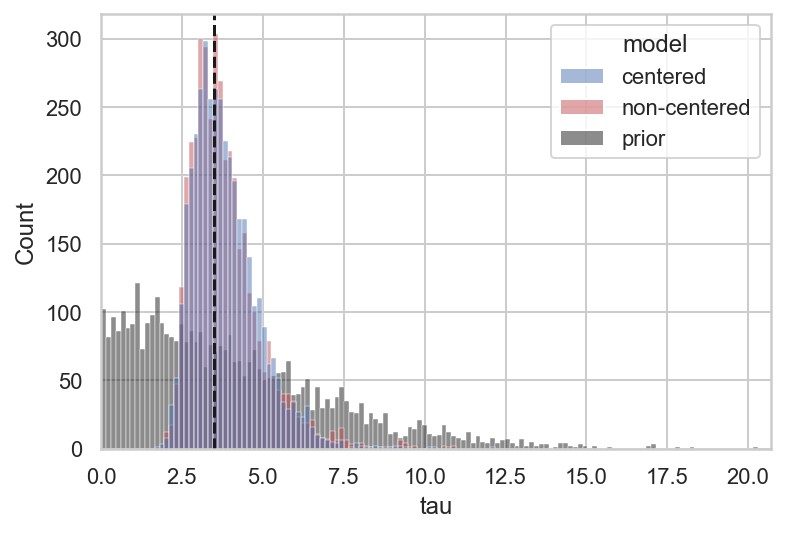

In [31]:
tau_post = pd.DataFrame(
    {
        "centered": cp_trace.posterior["tau"].values.flatten(),
        "non-centered": ncp_trace.posterior["tau"].values.flatten(),
        "prior": np.abs(np.random.normal(0, 5, 4000)),
    }
).pivot_longer(names_to="model", values_to="tau")

sns.histplot(
    data=tau_post,
    x="tau",
    hue="model",
    palette={"centered": "b", "non-centered": "r", "prior": "k"},
)
plt.xlim(0, tau_post.tau.max() * 1.02)
plt.axvline(data["tau"], color="k", linestyle="--")
plt.show();

### Unbalanced Likelihood Functions

---

In [32]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-15

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 20.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: mixed-parameterization

arviz     : 0.11.2
matplotlib: 3.3.4
pymc3     : 3.11.1
numpy     : 1.20.1
pandas    : 1.2.3
seaborn   : 0.11.1
plotnine  : 0.8.0
janitor   : 0.20.14

